# Template Live data

### Import Library

In [16]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import time
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import requests

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [17]:
USER_AGENTS = [
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 12_3_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36"
]

HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
VNDIRECT_DATA_HISTORY_URL = 'https://dchart-api.vndirect.com.vn/dchart/history'
URL = VNDIRECT_DATA_HISTORY_URL

In [18]:
def getStockHistoryData(ticker, timestamp_from=0, timestamp_to=0):
    if timestamp_from == 0:
        three_months = date.today() + relativedelta(months=-3)
        timestamp_from = datetime.strptime(three_months.strftime("%m/%d/%Y") + ', 00:00:0', "%m/%d/%Y, %H:%M:%S")\
            .timestamp()
    if timestamp_to == 0:
        timestamp_to = datetime.strptime(date.today().strftime("%m/%d/%Y") + ', 23:59:00', "%m/%d/%Y, %H:%M:%S")\
            .timestamp()

    params = {
        "resolution": "5",
        "symbol": str(ticker),
        "from": int(timestamp_from),
        "to": int(timestamp_to)
    }

    x = requests.get(URL, params=params, headers=HEADERS)
    response = x.json()

    import numpy as np
    import pandas as pd

    timestamp = np.array(response['t']).astype(int)
    close = np.array(response['c']).astype(float)
    open = np.array(response['o']).astype(float)
    high = np.array(response['h']).astype(float)
    low = np.array(response['l']).astype(float)
    volume = np.array(response['v']).astype(int)

    dataset = pd.DataFrame({'Time': timestamp, 'Open': list(open), 'High': list(high), 'Low': list(low),
                            'Close': list(close), 'Volume': list(volume)},
                           columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    return dataset

In [19]:
def prepareData(htd):
    if 'Time' in htd.columns:
        from datetime import datetime

        htd['DateStr'] = htd.apply(
            lambda x: datetime.fromtimestamp(x['Time']).strftime("%Y-%m-%d %H:%M:%S"), axis=1)

    htd['Date'] = pd.to_datetime(htd['DateStr'])
    ticker_data = htd.set_index('Date')
    ticker_data.drop(columns=['Time', 'DateStr'], inplace=True)
    return ticker_data

### Load Price Data

In [20]:
ticker = "VN30F1M"
htd = getStockHistoryData(ticker, 0, 0)
ticker_data = prepareData(htd)
ticker_data = ticker_data.dropna()
ticker_data

,Open,High,Low,Close,Volume
Date,,,,,
2024-07-23 09:00:00,1301.5,1302.7,1301.5,1302.2,4581
2024-07-23 09:05:00,1302.2,1302.4,1300.9,1301.9,2358
2024-07-23 09:10:00,1301.9,1302.1,1301.2,1301.8,1474
2024-07-23 09:15:00,1302.0,1303.6,1301.8,1303.3,3480
2024-07-23 09:20:00,1303.3,1303.7,1301.9,1302.0,3734
...,...,...,...,...,...
2024-10-23 10:45:00,1347.5,1348.2,1347.1,1347.7,3104
2024-10-23 10:50:00,1347.6,1347.7,1346.7,1347.1,3284
2024-10-23 10:55:00,1347.1,1348.6,1347.0,1348.4,3402


In [21]:
def prepare_clustering_data(htd):
    htd['input_1'] = htd['Close'] - htd['High']
    htd['input_2'] = htd['Close'] - htd['Low']
    htd['input_3'] = htd['Close'] - htd['Open']
    #
    htd['input_4'] = htd['Close'] - htd['High'].shift(1)
    htd['input_5'] = htd['Close'] - htd['Low'].shift(1)
    htd['input_6'] = htd['Close'] - htd['Open'].shift(1)
    htd['input_7'] = htd['Close'] - htd['Close'].shift(1)
    #
    htd['input_8'] = htd['Close'] - htd['High'].shift(2)
    htd['input_9'] = htd['Close'] - htd['Low'].shift(2)
    htd['input_10'] = htd['Close'] - htd['Open'].shift(2)
    htd['input_11'] = htd['Close'] - htd['Close'].shift(2)
    htd.round({'input_1': 1, 'input_2': 1, 'input_3': 1, 'input_4': 1, 'input_5': 1, 'input_6': 1, 'input_7': 1,
               'input_8': 1, 'input_9': 1, 'input_10': 1, 'input_11': 1})
    #
    htd.dropna(inplace=True)
    return htd

In [22]:
def prepare_data(htd):
    htd["current"] = htd.index + pd.DateOffset(minutes=5)
    htd = prepare_clustering_data(htd)
    # Clustering
    kmeans = load_brain()
    cluster_cols = ["input_1", "input_2", "input_3", "input_4",
                    "input_5", "input_6", "input_7", "input_8",
                    "input_9", "input_10", "input_11"]
    cluster = kmeans.predict(htd[cluster_cols])
    htd = htd.assign(cluster=cluster)
    #
    back_bar = 10
    htd['max_prev'] = htd['High'].rolling(back_bar).max()
    htd['min_prev'] = htd['Low'].rolling(back_bar).min()
    htd['is_r_keylevel'] = htd.apply(
        lambda r: True if r['High'] >= r['max_prev'] else False, axis=1)
    htd['is_s_keylevel'] = htd.apply(
        lambda r: True if r['Low'] <= r['min_prev'] else False, axis=1)
    htd['prev_is_r_keylevel'] = htd['is_r_keylevel'].shift(1)
    htd['prev_is_s_keylevel'] = htd['is_s_keylevel'].shift(1)
    htd["RSI"] = ta.rsi(htd["Close"], length=14)
    htd['cluster_group'] = htd.apply(lambda r: group_cluster(r), axis=1)
    htd['prev_cluster_group'] = htd['cluster_group'].shift(1)
    htd['signal'] = htd.apply(lambda r: cal_signal(r), axis=1)
    htd['prev_signal'] = htd['signal'].shift(1)
    return htd


def group_cluster(row):
    group = 0
    if row['cluster'] in [47, 194, 188, 130, 104, 149, 169,  36, 107, 108, 109,  94, 155,  83,
        10,  22,  98, 125,  20,  32,  89,  30,  15, 148, 171,  81, 100,  88,
       196, 120, 181, 198,  68, 140, 190, 105,  56, 134,  48,  64, 184,   5,
       129, 112,  67, 121,  69,  52,  40,  46,  73,   9, 136,  77, 124,  27,
        26, 110,  21, 102, 180, 150, 123, 137, 189, 193,  60, 101,  96, 187,
        28,  13,  12,  97,   7, 172, 170, 146, 163, 162,  54, 119, 118, 117,
       113, 151,  37,  33, 182,  44,  61,  19,  99, 131, 192, 156,  55, 197,
       168]:
        # Long
        group = 1
    elif row['cluster'] in [39,  81,  22,  35,  42,  84,   4,  99,  75,  62,  92, 127,  14, 139,
       119, 143, 167, 173,  61, 189,   8,  95, 111,  70,  78,  31, 103, 115,
       162, 116, 114, 188, 138,  58,  76, 170,  34, 132,   0,  85,  55,  17,
        24, 187,  82,  71, 177, 134, 152,   2, 181, 113,  53, 131, 175,  41,
       165,  30, 182,  65,  19,  18,  45,  36, 191,  97,  43, 124, 141,  27,
        91, 169, 183, 185,  98, 153, 135,   6,  63,  26,  12, 190,  29,  59,
       178,  86, 176,  74,  80, 144,  93, 168,  96, 166, 163, 102, 161, 140,
       194]:
        # Short
        group = -1
    return group


def cal_signal(row):
    signal = ''
    if row['prev_cluster_group'] == 1 and row['RSI'] < 60 and row['prev_is_s_keylevel'] and \
            row['Low'] > row['min_prev'] and row['Close'] > row['Open']:
        signal = 'long'
    elif row['prev_cluster_group'] == -1 and row['RSI'] > 40 and row['prev_is_r_keylevel'] and row['High'] < row['max_prev'] \
            and row['Close'] < row['Open']:
        signal = 'short'
    return signal

In [23]:
def load_brain():
    from pathlib import Path
    import pickle
    import os
    notebook_path = os.getcwd()
    algo_dir = Path(notebook_path).parent.parent.parent
    trainner_file = str(algo_dir) + '/VN30ps/clusters/v2/cluster_v2.pickle'
    try:
        with open(trainner_file, 'rb') as fp:
            return pickle.load(fp)
    except FileNotFoundError:
        print('You need to train a network first')
        return

In [24]:
prepared_data = prepare_data(ticker_data)

In [25]:
prepared_data[prepared_data.index =='2024-10-22 13:45:00'][["input_1", "input_2", "input_3", "input_4",
                    "input_5", "input_6", "input_7", "input_8",
                    "input_9", "input_10", "input_11"]]

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11
Date,,,,,,,,,,,
2024-10-22 13:45:00,-1.3,0.1,-0.3,-0.6,0.6,0.4,-0.3,0.2,1.3,1.2,0.2


In [26]:
today = prepared_data[(prepared_data.index > '2024-10-23 08:20:00') & (prepared_data.index < '2024-10-23 14:50:00')]
today.drop(columns=["input_1", "input_2", "input_3", "input_4",
                    "input_5", "input_6", "input_7", "input_8",
                    "input_9", "input_10", "input_11"], inplace=True)

In [27]:
today[today.signal != '']

,Open,High,Low,Close,Volume,current,cluster,max_prev,min_prev,is_r_keylevel,is_s_keylevel,prev_is_r_keylevel,prev_is_s_keylevel,RSI,cluster_group,prev_cluster_group,signal,prev_signal
Date,,,,,,,,,,,,,,,,,,


In [28]:
today
# today[(today.is_r_keylevel==True) | (today.is_s_keylevel==True)]

,Open,High,Low,Close,Volume,current,cluster,max_prev,min_prev,is_r_keylevel,is_s_keylevel,prev_is_r_keylevel,prev_is_s_keylevel,RSI,cluster_group,prev_cluster_group,signal,prev_signal
Date,,,,,,,,,,,,,,,,,,
2024-10-23 09:00:00,1353.0,1353.0,1351.8,1352.6,4974,2024-10-23 09:05:00,185,1362.6,1350.0,False,False,False,False,26.392026,-1,1.0,,
2024-10-23 09:05:00,1352.6,1352.9,1352.4,1352.5,928,2024-10-23 09:10:00,62,1362.0,1350.0,False,False,False,False,26.169220,-1,-1.0,,
2024-10-23 09:10:00,1352.6,1352.8,1352.1,1352.8,1384,2024-10-23 09:15:00,62,1360.5,1350.0,False,False,False,False,28.129469,-1,-1.0,,
2024-10-23 09:15:00,1352.9,1353.6,1352.6,1353.4,2780,2024-10-23 09:20:00,28,1360.2,1350.0,False,False,False,False,32.017126,1,-1.0,,
2024-10-23 09:20:00,1353.6,1354.4,1352.5,1352.6,3614,2024-10-23 09:25:00,54,1360.2,1350.0,False,False,False,False,29.709547,1,1.0,,
2024-10-23 09:25:00,1352.7,1353.0,1350.7,1350.7,4005,2024-10-23 09:30:00,169,1357.0,1350.0,False,False,False,False,25.085293,1,1.0,,
2024-10-23 09:30:00,1350.7,1351.8,1350.2,1351.5,5445,2024-10-23 09:35:00,159,1354.4,1350.0,False,False,False,False,30.024027,0,1.0,,
2024-10-23 09:35:00,1351.7,1352.4,1351.5,1352.1,2853,2024-10-23 09:40:00,111,1354.4,1350.2,False,False,False,False,33.561664,-1,0.0,,
2024-10-23 09:40:00,1352.0,1352.8,1351.9,1352.6,2087,2024-10-23 09:45:00,3,1354.4,1350.2,False,False,False,False,36.445141,0,-1.0,,


In [29]:
supply_data = prepared_data[prepared_data['is_r_keylevel'] == True]
demand_data = prepared_data[prepared_data['is_s_keylevel'] == True]
normal_data = prepared_data[(prepared_data['is_r_keylevel'] != True) & (prepared_data['is_s_keylevel'] != True)]

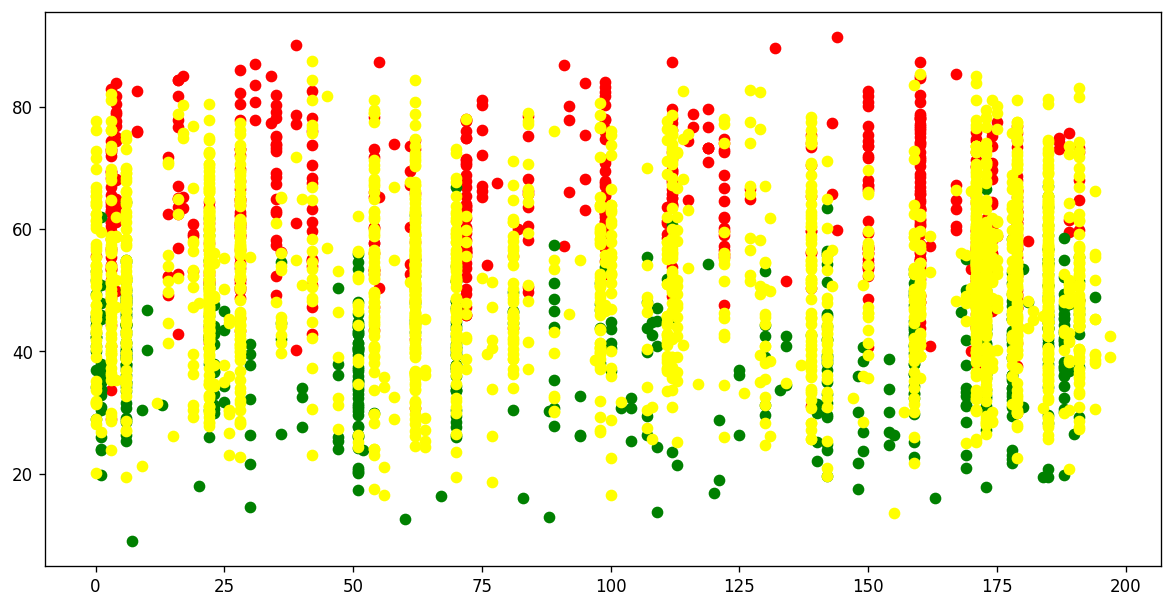

In [30]:
plt.scatter(supply_data['cluster'], supply_data['RSI'], c='red')
plt.scatter(demand_data['cluster'], demand_data['RSI'], c='green')
plt.scatter(normal_data['cluster'], normal_data['RSI'], c='yellow')